In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.selection import DropCorrelatedFeatures
import joblib
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
df.columns = [col.lower() for col in df.columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    int64  
 1   glucose                   768 non-null    int64  
 2   bloodpressure             768 non-null    int64  
 3   skinthickness             768 non-null    int64  
 4   insulin                   768 non-null    int64  
 5   bmi                       768 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
def grab_cols(df):
    num_cols = list(df.select_dtypes(include="number"))
    cat_cols = [col for col in df.columns if col not in num_cols]
    num_but_cat = [col for col in num_cols if df[col].nunique()<10]
    cat_but_car = [col for col in cat_cols if df[col].nunique() >20]
    cat_cols = cat_cols + num_but_cat 
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"cat_cols = {len(cat_cols)}")
    print(f"num_cols = {len(num_cols)}")
    print(f"num_but_cat = {len(num_but_cat)}")
    print(f"cat_but_car= {len(cat_but_car)}")
    return cat_cols,num_cols,cat_but_car,num_but_cat

cat_cols,num_cols,cat_but_car,num_but_cat = grab_cols(df)

cat_cols = 1
num_cols = 8
num_but_cat = 1
cat_but_car= 0


In [6]:
X = df.drop("outcome",axis=1)
y =df["outcome"]

In [7]:
df.loc[df["glucose"]==0,"glucose"]

75     0
182    0
342    0
349    0
502    0
Name: glucose, dtype: int64

In [8]:
cols=["glucose","bloodpressure","skinthickness","insulin","bmi"]

for col in cols:
    X.loc[X[col]==0,col] = np.nan
    

for col in cols:
    df.loc[df[col]==0,col] = np.nan

In [9]:
df.isnull().sum()

pregnancies                   0
glucose                       5
bloodpressure                35
skinthickness               227
insulin                     374
bmi                          11
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

In [10]:
X.isnull().sum()

pregnancies                   0
glucose                       5
bloodpressure                35
skinthickness               227
insulin                     374
bmi                          11
diabetespedigreefunction      0
age                           0
dtype: int64

In [11]:
def outliers(df,variable):
    q1= df[variable].quantile(0.2)
    q3 = df[variable].quantile(0.8)
    iqr = q3 - q1
    lower_lim = q1 - 1.5*iqr
    upper_lim = q3 + 1.5*iqr
    return lower_lim,upper_lim

def check_outliers(df,variable):
    lower_lim,upper_lim = outliers(df,variable)
    if df.loc[(df[variable]<lower_lim) | (df[variable]>upper_lim)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col,check_outliers(X,col))

pregnancies True
glucose False
bloodpressure True
skinthickness True
insulin True
bmi True
diabetespedigreefunction True
age True


In [12]:
def replace_outliers(X,col):
    lower_lim,upper_lim = outliers(X,col)
    X[col].clip(lower=lower_lim,upper=upper_lim,inplace=True)

replace_outliers(X,"insulin")

In [13]:
for col in num_cols:
    print(col,check_outliers(X,col))

pregnancies True
glucose False
bloodpressure True
skinthickness True
insulin False
bmi True
diabetespedigreefunction True
age True


In [14]:
X.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,149.717259,32.457464,0.471876,33.240885
std,3.369578,30.535641,12.382158,10.476982,98.583962,6.924988,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,421.200000,67.100000,2.420000,81.000000


In [15]:
df.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [16]:
X.isnull().sum()

pregnancies                   0
glucose                       5
bloodpressure                35
skinthickness               227
insulin                     374
bmi                          11
diabetespedigreefunction      0
age                           0
dtype: int64

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
imp_missforest = IterativeImputer(
    estimator=XGBRegressor(n_estimators=300,max_depth=5),
    max_iter=30,
    initial_strategy="median",
    random_state=0
).set_output(transform="pandas")

X=imp_missforest.fit_transform(X)

c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<Axes: ylabel='Density'>

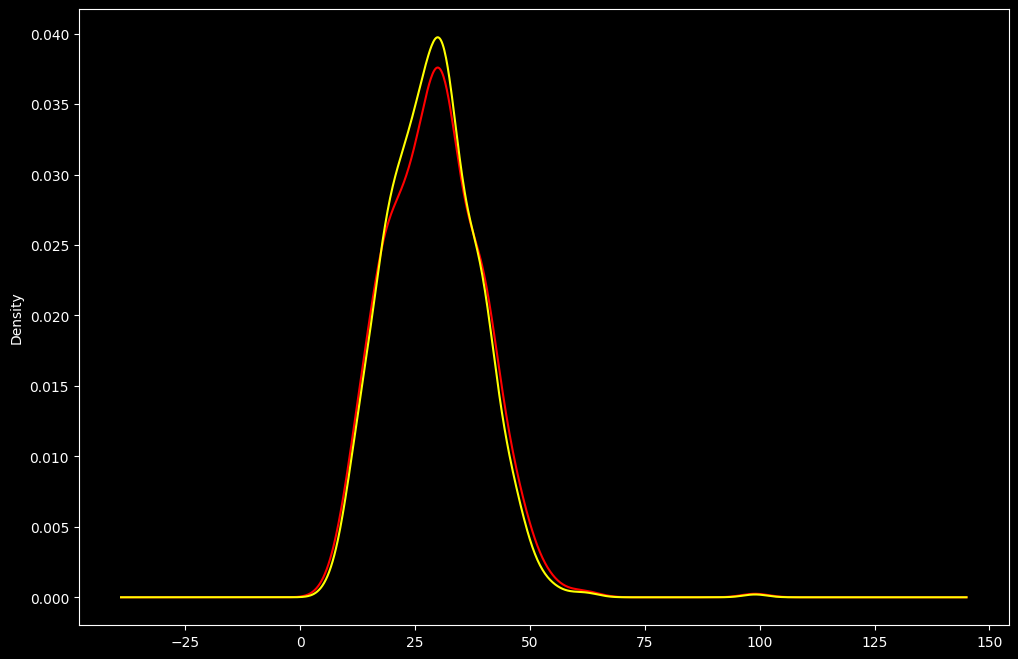

In [18]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

df["skinthickness"].plot(kind="kde",ax=ax,color="red")
X["skinthickness"].plot(kind="kde",ax=ax,color="yellow")

In [19]:
X

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age
0,6.0,148.0,72.0,35.000000,154.773224,33.6,0.627,50.0
1,1.0,85.0,66.0,29.000000,90.675652,26.6,0.351,31.0
2,8.0,183.0,64.0,19.712955,212.730850,23.3,0.672,32.0
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0
764,2.0,122.0,70.0,27.000000,191.746689,36.8,0.340,27.0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0
766,1.0,126.0,60.0,28.947565,124.111694,30.1,0.349,47.0


In [20]:
from sklearn.model_selection import cross_val_score
rf= RandomForestClassifier(n_estimators=300,max_depth=5)
cross_val_score(rf,X,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

0.8435840455840455

In [21]:
from feature_engine.selection import DropCorrelatedFeatures
sel = DropCorrelatedFeatures(
    threshold=0.7,
    method='spearman',
    missing_values='ignore'
)


# find correlated features

sel.fit(X)
sel.correlated_feature_sets_

[{'bmi', 'skinthickness'}]

In [22]:
X.groupby(y)["glucose"].mean()

outcome
0    110.545294
1    142.314242
Name: glucose, dtype: float64

In [23]:
for col in list(X.columns):
    print(X.groupby(y)[col].mean())
    print()

outcome
0    3.298000
1    4.865672
Name: pregnancies, dtype: float64

outcome
0    110.545294
1    142.314242
Name: glucose, dtype: float64

outcome
0    70.833626
1    75.371099
Name: bloodpressure, dtype: float64

outcome
0    27.10066
1    32.10839
Name: skinthickness, dtype: float64

outcome
0    125.688091
1    189.895373
Name: insulin, dtype: float64

outcome
0    30.838648
1    35.393329
Name: bmi, dtype: float64

outcome
0    0.429734
1    0.550500
Name: diabetespedigreefunction, dtype: float64

outcome
0    31.190000
1    37.067164
Name: age, dtype: float64



In [24]:
def ohe(dataframe,cat_cols):
    dataframe = pd.get_dummies(dataframe,columns=cat_cols,drop_first=True,dtype=int)
    return dataframe

In [25]:
X.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.631333,72.417015,28.848149,148.093757,32.428042,0.471876,33.240885
std,3.369578,30.535643,12.205386,9.858133,85.995831,6.894199,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,22.000000,86.029652,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,28.973783,130.000000,32.250000,0.372500,29.000000
75%,6.000000,141.000000,80.000000,35.000000,190.399586,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,421.200000,67.100000,2.420000,81.000000


In [26]:
X["new_glucose_cat"] = pd.cut(x=X["glucose"],bins=[-1,100,140,200],labels=["normal","prediabetes","danger"])

X.loc[X["age"]<32,"new_age_cat"] = 0
X.loc[(X["age"]>=32) & (X["age"]<=50),"new_age_cat"]= 1
X.loc[X["age"]>50,"new_age_cat"] =2

# X["new_age2"] = pd.cut(x=X["age"],bins=[-1,32,50,100],labels= [0,1,2]) # alt sınıfa dahil eder

X["new_bmi"] = pd.cut(x=X["bmi"],bins=[-1,18.5,24.9,29.9,100],labels=["underweight","healthy","overweight","obese"])
X["new_bloodpressure"] = pd.cut(x=X["bloodpressure"],bins=[-1,79,89,123],labels=["normal","hs1","hs2"])

In [27]:
X

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,new_glucose_cat,new_age_cat,new_bmi,new_bloodpressure
0,6.0,148.0,72.0,35.000000,154.773224,33.6,0.627,50.0,danger,1.0,obese,normal
1,1.0,85.0,66.0,29.000000,90.675652,26.6,0.351,31.0,normal,0.0,overweight,normal
2,8.0,183.0,64.0,19.712955,212.730850,23.3,0.672,32.0,danger,1.0,healthy,normal
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,normal,0.0,overweight,normal
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,prediabetes,1.0,obese,normal
...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,prediabetes,2.0,obese,normal
764,2.0,122.0,70.0,27.000000,191.746689,36.8,0.340,27.0,prediabetes,0.0,obese,normal
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,prediabetes,0.0,overweight,normal
766,1.0,126.0,60.0,28.947565,124.111694,30.1,0.349,47.0,prediabetes,1.0,obese,normal


In [28]:
X["new_bloodpressure"].value_counts()

new_bloodpressure
normal    556
hs1       151
hs2        61
Name: count, dtype: int64

In [29]:
X.isnull().sum()

pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
new_glucose_cat             0
new_age_cat                 0
new_bmi                     0
new_bloodpressure           0
dtype: int64

In [30]:
# num_cols = [col for col in X.columns if np.issubdtype(X[col],np.number)]


In [31]:
cat_cols,num_cols,cat_but_car,num_but_cat = grab_cols(X)

cat_cols = 4
num_cols = 8
num_but_cat = 1
cat_but_car= 0


In [32]:
cat_cols 

['new_glucose_cat', 'new_bmi', 'new_bloodpressure', 'new_age_cat']

In [33]:
num_cols 

['pregnancies',
 'glucose',
 'bloodpressure',
 'skinthickness',
 'insulin',
 'bmi',
 'diabetespedigreefunction',
 'age']

In [34]:
num_but_cat 

['new_age_cat']

In [35]:
df = pd.concat([X,y],axis=1)

In [36]:
def rare_analysis(df,target,cat_cols):
    for col in cat_cols:
        print(col,":",len(df[col].value_counts()))
        df_ratio = (df[col].value_counts() /len(df)).sort_values(ascending=False)
        df_count = df[col].value_counts().loc[df_ratio.index]
        df_target_mean = df.groupby(col)[target].mean().loc[df_ratio.index]
        print(pd.DataFrame({"Ratio": df_ratio,
              "Count": df_count,
              "Target_Mean": df_target_mean}))
        print("-------------------------------------------------------")
        
rare_analysis(df,"outcome",cat_cols)

new_glucose_cat : 3
                    Ratio  Count  Target_Mean
new_glucose_cat                              
prediabetes      0.473958    364     0.321429
normal           0.274740    211     0.085308
danger           0.251302    193     0.689119
-------------------------------------------------------
new_bmi : 4
                Ratio  Count  Target_Mean
new_bmi                                  
obese        0.623698    479     0.461378
overweight   0.236979    182     0.219780
healthy      0.134115    103     0.067961
underweight  0.005208      4     0.000000
-------------------------------------------------------
new_bloodpressure : 3
                      Ratio  Count  Target_Mean
new_bloodpressure                              
normal             0.723958    556     0.312950
hs1                0.196615    151     0.423841
hs2                0.079427     61     0.491803
-------------------------------------------------------
new_age_cat : 3
                Ratio  Count  Target_Mea

In [37]:
X=ohe(X,cat_cols)

In [38]:
X

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,new_glucose_cat_prediabetes,new_glucose_cat_danger,new_bmi_healthy,new_bmi_overweight,new_bmi_obese,new_bloodpressure_hs1,new_bloodpressure_hs2,new_age_cat_1.0,new_age_cat_2.0
0,6.0,148.0,72.0,35.000000,154.773224,33.6,0.627,50.0,0,1,0,0,1,0,0,1,0
1,1.0,85.0,66.0,29.000000,90.675652,26.6,0.351,31.0,0,0,0,1,0,0,0,0,0
2,8.0,183.0,64.0,19.712955,212.730850,23.3,0.672,32.0,0,1,1,0,0,0,0,1,0
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0,0,0,1,0,0,0,0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,1,0,0,0,1,0,0,0,1
764,2.0,122.0,70.0,27.000000,191.746689,36.8,0.340,27.0,1,0,0,0,1,0,0,0,0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,1,0,0,1,0,0,0,0,0
766,1.0,126.0,60.0,28.947565,124.111694,30.1,0.349,47.0,1,0,0,0,1,0,0,1,0


In [39]:
cross_val_score(rf,X,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

0.841951566951567

In [140]:
from feature_engine.creation import RelativeFeatures
references = ["insulin","skinthickness","glucose","bmi","age","diabetespedigreefunction","bloodpressure"]

creator = RelativeFeatures(
    variables=["pregnancies","insulin","skinthickness","glucose","bmi","age","diabetespedigreefunction","bloodpressure"],
    reference=references,
    func=["div","sub","add"]
)
X2=creator.fit_transform(X)

c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\creation\relative_features.py:224: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[varname] = X[self.variables].sub(X[reference], axis=0)
c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_engine\creation\relative_features.py:224: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[varname] = X[self.variables].sub(X[reference], axis=0)
c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\feature_e

In [141]:
X2

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,new_glucose_cat_prediabetes,new_glucose_cat_danger,...,diabetespedigreefunction_add_diabetespedigreefunction,bloodpressure_add_diabetespedigreefunction,pregnancies_add_bloodpressure,insulin_add_bloodpressure,skinthickness_add_bloodpressure,glucose_add_bloodpressure,bmi_add_bloodpressure,age_add_bloodpressure,diabetespedigreefunction_add_bloodpressure,bloodpressure_add_bloodpressure
0,6.0,148.0,72.0,35.000000,154.773224,33.6,0.627,50.0,0,1,...,1.254,72.627,78.0,226.773224,107.000000,220.0,105.6,122.0,72.627,144.0
1,1.0,85.0,66.0,29.000000,90.675652,26.6,0.351,31.0,0,0,...,0.702,66.351,67.0,156.675652,95.000000,151.0,92.6,97.0,66.351,132.0
2,8.0,183.0,64.0,19.712955,212.730850,23.3,0.672,32.0,0,1,...,1.344,64.672,72.0,276.730850,83.712955,247.0,87.3,96.0,64.672,128.0
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0,0,...,0.334,66.167,67.0,160.000000,89.000000,155.0,94.1,87.0,66.167,132.0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,1,0,...,4.576,42.288,40.0,208.000000,75.000000,177.0,83.1,73.0,42.288,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,1,0,...,0.342,76.171,86.0,256.000000,124.000000,177.0,108.9,139.0,76.171,152.0
764,2.0,122.0,70.0,27.000000,191.746689,36.8,0.340,27.0,1,0,...,0.680,70.340,72.0,261.746689,97.000000,192.0,106.8,97.0,70.340,140.0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,1,0,...,0.490,72.245,77.0,184.000000,95.000000,193.0,98.2,102.0,72.245,144.0
766,1.0,126.0,60.0,28.947565,124.111694,30.1,0.349,47.0,1,0,...,0.698,60.349,61.0,184.111694,88.947565,186.0,90.1,107.0,60.349,120.0


In [142]:
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures
sel = DropConstantFeatures(tol=0.95,variables=None,missing_values="ignore")
X2 = sel.transform(X2)

DropConstantFeatures(missing_values='ignore', tol=0.95)

In [145]:
cross_val_score(rf,X2,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

0.8378490028490028

In [147]:
from feature_engine.selection import DropCorrelatedFeatures
sel = DropCorrelatedFeatures(
    threshold=0.9,
    method='spearman',
    missing_values='ignore'
)


# find correlated features

sel.fit(X2)
sel.correlated_feature_sets_

[{'pregnancies',
  'pregnancies_add_diabetespedigreefunction',
  'pregnancies_div_age',
  'pregnancies_div_bloodpressure',
  'pregnancies_div_bmi',
  'pregnancies_div_glucose',
  'pregnancies_div_skinthickness',
  'pregnancies_sub_diabetespedigreefunction'},
 {'age_add_glucose',
  'age_sub_glucose',
  'bloodpressure_add_glucose',
  'bloodpressure_sub_glucose',
  'bmi_add_glucose',
  'bmi_sub_glucose',
  'diabetespedigreefunction_add_glucose',
  'diabetespedigreefunction_sub_glucose',
  'glucose',
  'glucose_add_age',
  'glucose_add_bloodpressure',
  'glucose_add_bmi',
  'glucose_add_diabetespedigreefunction',
  'glucose_add_glucose',
  'glucose_add_skinthickness',
  'glucose_sub_age',
  'glucose_sub_bloodpressure',
  'glucose_sub_bmi',
  'glucose_sub_diabetespedigreefunction',
  'glucose_sub_skinthickness',
  'pregnancies_add_glucose',
  'pregnancies_sub_glucose',
  'skinthickness_add_glucose',
  'skinthickness_sub_glucose'},
 {'bloodpressure',
  'bloodpressure_add_bloodpressure',
  'b

In [149]:
X2=sel.transform(X2)

In [153]:
cross_val_score(rf,X2,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

0.8387264957264957

In [41]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10,n_jobs=-1)
lof.fit_predict(X)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [42]:
X_scores = lof.negative_outlier_factor_
np.sort(X_scores)[0:5]

array([-2.5302114 , -2.20144378, -2.18001554, -2.09165457, -1.97170547])

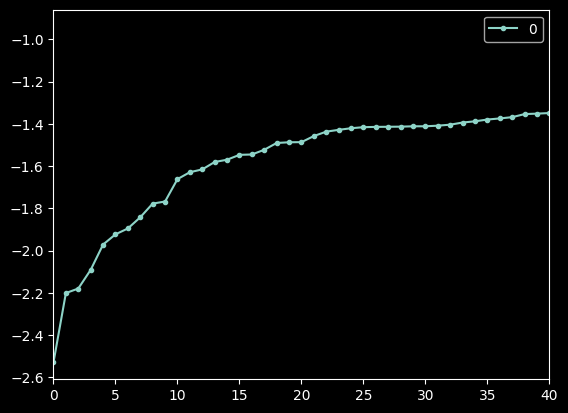

In [43]:
scores = pd.DataFrame(np.sort(X_scores))
scores.plot(stacked=True,xlim=[0,40],style=".-")
plt.show()

In [44]:
X_scores<-1.8

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,

In [45]:
X_scores[X_scores<-1.8]

array([-1.97170547, -2.09165457, -1.89549118, -2.20144378, -1.84251151,
       -2.18001554, -2.5302114 , -1.92332034])

In [46]:
X[X_scores<-1.8]

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,new_glucose_cat_prediabetes,new_glucose_cat_danger,new_bmi_healthy,new_bmi_overweight,new_bmi_obese,new_bloodpressure_hs1,new_bloodpressure_hs2,new_age_cat_1.0,new_age_cat_2.0
106,1.0,96.0,122.0,21.039455,48.929935,22.4,0.207,27.0,0,0,1,0,0,0,1,0,0
125,1.0,88.0,30.0,42.000000,99.000000,55.0,0.496,26.0,0,0,0,0,1,0,0,0,0
177,0.0,129.0,110.0,46.000000,130.000000,67.1,0.319,26.0,1,0,0,0,1,0,1,0,0
445,0.0,180.0,78.0,63.000000,14.000000,59.4,2.420,25.0,0,1,0,0,1,0,0,0,0
459,9.0,134.0,74.0,33.000000,60.000000,25.9,0.460,81.0,1,0,0,1,0,0,0,0,1
537,0.0,57.0,60.0,12.888480,93.323524,21.7,0.735,67.0,0,0,1,0,0,0,0,0,1
579,2.0,197.0,70.0,99.000000,211.651688,34.7,0.575,62.0,0,1,0,0,1,0,0,0,1
597,1.0,89.0,24.0,19.000000,25.000000,27.8,0.559,21.0,0,0,0,1,0,0,0,0,0


In [47]:
df = pd.concat([X,y],axis=1)

In [48]:
list(df[X_scores<-1.8].index)

[106, 125, 177, 445, 459, 537, 579, 597]

In [49]:
df=df.drop(labels =list(df[X_scores<-1.8].index),axis=0 )

In [50]:
X=df.drop("outcome",axis=1)
y = df["outcome"]
cross_val_score(rf,X,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

0.8446262573405431

In [51]:
cross_val_score(rf,X,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7684210526315789

In [52]:
xg = XGBClassifier(n_estimators=400,max_depth=2)
cross_val_score(xg,X,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7486842105263158

In [ ]:
from feature_engine.creation import RelativeFeatures
references = ["insulin","skinthickness","glucose","bmi","age","diabetespedigreefunction","bloodpressure"]

creator = RelativeFeatures(
    variables=["pregnancies","insulin","skinthickness","glucose","bmi","age","diabetespedigreefunction","bloodpressure"],
    reference=references,
    func=["div","sub","add"]
)
X2=creator.fit_transform(X)
sel = DropConstantFeatures(tol=0.95,variables=None,missing_values="ignore")
X2 = sel.fit_transform(X2)
sel = DropCorrelatedFeatures(
    threshold=0.9,
    method='spearman',
    missing_values='ignore'
)


# find correlated features

X2=sel.fit_transform(X2)

In [225]:
cross_val_score(xg,X2,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7539473684210527

In [224]:
cross_val_score(rf,X2,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7644736842105263

In [53]:
sc = StandardScaler().set_output(transform="pandas")
X = sc.fit_transform(X)

In [54]:
X

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,new_glucose_cat_prediabetes,new_glucose_cat_danger,new_bmi_healthy,new_bmi_overweight,new_bmi_obese,new_bloodpressure_hs1,new_bloodpressure_hs2,new_age_cat_1.0,new_age_cat_2.0
0,0.633702,0.869437,-0.036565,0.667253,0.070035,0.186704,0.485557,1.458321,-0.953702,1.725995,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,1.445486,-0.338186
1,-0.851843,-1.208138,-0.544486,0.030784,-0.675924,-0.864077,-0.363975,-0.186077,-0.953702,-0.579376,-0.391488,1.795055,-1.290994,-0.497943,-0.290113,-0.691809,-0.338186
2,1.227920,2.023646,-0.713794,-0.954370,0.744538,-1.359445,0.624067,-0.099529,-0.953702,1.725995,2.554360,-0.557086,-1.290994,-0.497943,-0.290113,1.445486,-0.338186
3,-0.851843,-1.076228,-0.544486,-0.605686,-0.637236,-0.638909,-0.930330,-1.051549,-0.953702,-0.579376,-0.391488,1.795055,-1.290994,-0.497943,-0.290113,-0.691809,-0.338186
4,-1.148952,0.506686,-2.745481,0.667253,0.223966,1.612764,5.598139,-0.012982,1.048545,-0.579376,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,1.445486,-0.338186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.822138,-0.680500,0.302050,2.046271,0.363620,0.081626,-0.918018,2.583435,1.048545,-0.579376,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,-0.691809,2.956956
764,-0.554734,0.012025,-0.205872,-0.181373,0.500327,0.667061,-0.397833,-0.532265,1.048545,-0.579376,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,-0.691809,-0.338186
765,0.336593,-0.020952,-0.036565,-0.605686,-0.427754,-0.924121,-0.690245,-0.272624,1.048545,-0.579376,-0.391488,1.795055,-1.290994,-0.497943,-0.290113,-0.691809,-0.338186
766,-0.851843,0.143935,-1.052408,0.025221,-0.286800,-0.338686,-0.370131,1.198679,1.048545,-0.579376,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,1.445486,-0.338186


In [55]:
lr = LogisticRegression()
cross_val_score(lr,X,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7763157894736842

In [242]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

def evaluate_models(X, y,scoring="roc_auc"):
    """
    Çeşitli sınıflandırıcıları kullanarak çapraz doğrulama skorlarını hesaplar ve sıralar.
    
    Parametreler:
    - X: Özellik matrisi
    - y: Hedef değişken
    
    Geri döndürür:
    - Sıralanmış model isimleri ve skorları
    """
    
    models = {
        'RandomForest': RandomForestClassifier(),
        'SVM': SVC(),
        'LogisticRegression': LogisticRegression(),
        'XGBoost': XGBClassifier(eval_metric='logloss'),
        'AdaBoost': AdaBoostClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0)
    }

    scores = {}
    for name, model in models.items():
        score = cross_val_score(model, X, y, cv=10,scoring=scoring).mean()
        scores[name] = score

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_scores

evaluate_models(X,y)


[('LogisticRegression', 0.8420824466538752),
 ('CatBoost', 0.8362683876969591),
 ('SVM', 0.8274335717192859),
 ('RandomForest', 0.8244827315541603),
 ('AdaBoost', 0.8072318448747019),
 ('XGBoost', 0.7965820105820105)]

In [244]:
evaluate_models(X,y,scoring="accuracy")

[('LogisticRegression', 0.7763157894736842),
 ('CatBoost', 0.7644736842105263),
 ('RandomForest', 0.761842105263158),
 ('AdaBoost', 0.7526315789473685),
 ('SVM', 0.7526315789473683),
 ('XGBoost', 0.7355263157894738)]

In [257]:
from sklearn.ensemble import BaggingClassifier
bagging_log_reg = BaggingClassifier(
    base_estimator=lr,
    n_estimators=300,    # 300 bootstrap örnek
    bootstrap=True,     # Bootstrap örneklemesi yapılır
    n_jobs=-1,          # Tüm CPU çekirdeklerini kullan (eğer isterseniz kullanabilirsiniz)
    random_state=42     # Sonuçların tekrar edilebilir olmasını sağlamak için rastgelelik durumu
)
cross_val_score(bagging_log_reg,X,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

0.8416262573405431

In [263]:
cross_val_score(bagging_log_reg,X,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.775

In [254]:
cross_val_score(lr,X,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

0.8420824466538752

In [56]:
xg = XGBClassifier(n_estimators=400,max_depth=2)
rf= RandomForestClassifier(n_estimators=300,max_depth=5)
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('xg', xg), ('rf', rf)],
    voting='soft',
    weights=[4,1,3]  # Ağırlıkları belirtiyoruz
)
cross_val_score(voting_clf,X,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

0.8459165649165648

In [57]:
voting_clf2 = VotingClassifier(
    estimators=[('lr', lr), ('xg', xg), ('rf', rf)],
    voting='hard'
)
cross_val_score(voting_clf2,X,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7763157894736842

In [59]:
xg = XGBClassifier(n_estimators=400,max_depth=2,booster="gblinear")
cross_val_score(xg,X,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7776315789473685

In [145]:
xg = XGBClassifier(n_estimators=100,max_depth=2,booster="gblinear",reg_lambda=0.02,reg_alpha=0.01,objective ="binary:logistic")
cross_val_score(xg,X,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

0.8456302692016978

In [131]:
cross_val_score(xg,X,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7671052631578947

In [132]:
cross_val_score(lr,X,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7763157894736842

In [133]:
voting_clf2 = VotingClassifier(
    estimators=[('lr', lr), ('xg', xg), ('rf', rf)],
    voting='hard'
)
cross_val_score(voting_clf2,X,y,cv=10,n_jobs=-1,scoring="roc_auc").mean()

nan

In [146]:
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('xg', xg)],
    voting='soft',
    weights=[4,2]  # Ağırlıkları belirtiyoruz
)
cross_val_score(voting_clf,X,y,cv=10,n_jobs=-1,scoring="accuracy").mean()

0.7789473684210526

In [276]:
X

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,new_glucose_cat_prediabetes,new_glucose_cat_danger,new_bmi_healthy,new_bmi_overweight,new_bmi_obese,new_bloodpressure_hs1,new_bloodpressure_hs2,new_age_cat_1.0,new_age_cat_2.0
0,0.633702,0.869437,-0.036565,0.667253,0.070035,0.186704,0.485557,1.458321,-0.953702,1.725995,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,1.445486,-0.338186
1,-0.851843,-1.208138,-0.544486,0.030784,-0.675924,-0.864077,-0.363975,-0.186077,-0.953702,-0.579376,-0.391488,1.795055,-1.290994,-0.497943,-0.290113,-0.691809,-0.338186
2,1.227920,2.023646,-0.713794,-0.954370,0.744538,-1.359445,0.624067,-0.099529,-0.953702,1.725995,2.554360,-0.557086,-1.290994,-0.497943,-0.290113,1.445486,-0.338186
3,-0.851843,-1.076228,-0.544486,-0.605686,-0.637236,-0.638909,-0.930330,-1.051549,-0.953702,-0.579376,-0.391488,1.795055,-1.290994,-0.497943,-0.290113,-0.691809,-0.338186
4,-1.148952,0.506686,-2.745481,0.667253,0.223966,1.612764,5.598139,-0.012982,1.048545,-0.579376,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,1.445486,-0.338186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1.822138,-0.680500,0.302050,2.046271,0.363620,0.081626,-0.918018,2.583435,1.048545,-0.579376,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,-0.691809,2.956956
764,-0.554734,0.012025,-0.205872,-0.181373,0.500327,0.667061,-0.397833,-0.532265,1.048545,-0.579376,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,-0.691809,-0.338186
765,0.336593,-0.020952,-0.036565,-0.605686,-0.427754,-0.924121,-0.690245,-0.272624,1.048545,-0.579376,-0.391488,1.795055,-1.290994,-0.497943,-0.290113,-0.691809,-0.338186
766,-0.851843,0.143935,-1.052408,0.025221,-0.286800,-0.338686,-0.370131,1.198679,1.048545,-0.579376,-0.391488,-0.557086,0.774597,-0.497943,-0.290113,1.445486,-0.338186


In [279]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

# Keras modelini tanımlama
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

def create_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(12, input_dim=17, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

keras_clf = KerasClassifier(model=create_model, epochs=50, batch_size=10, verbose=0)
scores = cross_val_score(keras_clf, X, y, cv=10, scoring='accuracy')
print("Çapraz doğrulama ortalaması:", scores.mean())

Çapraz doğrulama ortalaması: 0.7618421052631579


In [280]:
scores = cross_val_score(keras_clf, X, y, cv=10, scoring='roc_auc')
print("Çapraz doğrulama ortalaması:", scores.mean())

Çapraz doğrulama ortalaması: 0.834386766672481


In [138]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

# Keras modelini tanımlama
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

def create_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(8, input_dim=17, activation='relu'))
    model.add(keras.layers.Dense(4, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

keras_clf = KerasClassifier(model=create_model, epochs=50, batch_size=10, verbose=0)
scores = cross_val_score(keras_clf, X, y, cv=10, scoring='accuracy')
print("Çapraz doğrulama ortalaması:", scores.mean())

Çapraz doğrulama ortalaması: 0.7671052631578946


In [140]:
random_user = X.sample(1,random_state=0)
random_user

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,new_glucose_cat_prediabetes,new_glucose_cat_danger,new_bmi_healthy,new_bmi_overweight,new_bmi_obese,new_bloodpressure_hs1,new_bloodpressure_hs2,new_age_cat_1.0,new_age_cat_2.0
756,0.930811,0.506686,1.487201,1.303723,-0.195522,-0.053474,-0.240855,0.506301,1.048545,-0.579376,-0.391488,-0.557086,0.774597,-0.497943,3.446934,1.445486,-0.338186


In [147]:
voting_clf.fit(X,y)
voting_clf.predict(random_user)

[11:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.



array([1], dtype=int64)

In [148]:
joblib.dump(voting_clf,"voting_clf.pkl")

['voting_clf.pkl']

In [149]:
new_model = joblib.load("voting_clf.pkl")
new_model.predict(random_user)

array([1], dtype=int64)